Tutorial 2: Parameter Space and Priors
======================================

In the previous example, we used a `NonLinearSearch` to infer the best-fit lens model of imaging-imaging of a strong
lens. In this example, we'll get a deeper intuition of how a `NonLinearSearch` works.

First, I want to develop the idea of a `parameter space`. Lets think of a function, like the simple function below:

f(x) = x^2

In this function, when we input a parameter x, it returns a value f(x). The mappings between different values of x and
f(x) define a parameter space (and if you remember your high school math classes, you'll remember this parameter
space is a parabola).

A function can of course have multiple parameters:

f(x, y, z) = x + y^2 - z^3

This function has 3 parameters, x, y and z. The mappings between x, y and z and f(x, y, z) again define a parameter
space, albeit now in 3 dimensions. Nevertheless, one could still picture this parameter space as some 3 dimensional
curved surface.

The process of computing a log likelihood in **PyAutoLens** can be visualized in exactly the same way. We have a set of
lens model parameters, which we input into **PyAutoLens**`s `log_likelihood function`. Now, this log likelihood function
isn't something that we can write down analytically and its inherently non-linear. But, nevertheless, it is a function;
if we put the same set of lens model parameters into it, we'll compute the same log likelihood.

We can write our log_likelihood function as follows (using x_mp, y_mp, I_lp etc. as short-hand notation for the
`MassProfile` and `LightProfile` parameters):

f(x_mp, y_mp, R_mp, x_lp, y_lp, I_lp, R_lp) = a log likelihood from **PyAutoLens**`s `Tracer` and `FitImaging` objects.

The point is, like we did for the simple functions above, we again have a parameter space! It can`t be written
down analytically and its undoubtedly very complex and non-linear. Fortunately, we've already learnt how to search
it, and find the solutions which maximize our log_likelihood function!

Lets inspect the results of the last tutorial's non-linear search. we're going to look at what are called `Probability
density functions` or `PDF's for short. These represent where the highest log likelihood regions of parameter space were
found for each parameter.

Navigate to the image folder in `autolens_workspace/output/howtolens/phase_t1_non_linear_search`
and open the `pdf_triangle.png` figure. The Gaussian shaped lines running down the diagonal of this triangle represent
1D estimates of the highest log likelihood regions that were found in parameter space for each parameter.

The remaining figures, which look like contour-maps, show the maximum log likelihood regions in 2D between every
parameter pair. We often see that two parameters are `degenerate`, whereby increasing one and decreasing the other
leads to a similar log_likelihood value. The 2D PDF between the source-`Galaxy`'s `LightProfile`'s intensity I and
effective radius R shows such a degeneracy. This makes sense - making the source galaxy brighter and smaller is
similar to making it fainter and bigger!

So, how does **PyAutoLens** know where to look in parameter space? A parameter, say, the Einstein Radius, could in
principle take any value between negative and positive infinity. **PyAutoLens** must of told it to only search regions of
parameter space with `reasonable` values (i.e. Einstein radii of around 1"-3").

These are our `priors` - which define where we tell the `NonLinearSearch` to search parameter space. These tutorials
use two types of prior:

UniformPrior:

 The values of a parameter are randomly drawn between a lower and upper limit. For example, the
 orientation angle phi of a `Profile` typically assumes a uniform prior between 0.0 and 180.0 degrees.

GaussianPrior:

 The values of a parameter are randomly drawn from a Gaussian distribution with a mean value and a
 width sigma. For example, an Einstein radius might assume a mean value of 1.0" and width of sigma = 1.0".

The default priors on all parameters can be found by navigating to the `autolens_workspace/config/priors/` folder,
and inspecting config files like light_profiles.json. The convention is as follow:

{
    "SphericalIsothermal": { <- The name of the `Profile` we are defining the default priors of.
        "einstein_radius": { <- The parameter of the `Profile` we are defining the default priors of.
            "type": "Gaussian", <- The type of prior, in this case a GaussianPrior (other priors are Uniform, LogUniform, etc.)
            "lower_limit": 0.0, <- The lower physical limit allowed for values of this parameter.
            "upper_limit": "inf", <- The upper physical limit allowed for values of this parameter.
            "width_modifier": {
                "type": "Relative", <- Ignore these for now.
                "value": 0.05
            },
            "mean": 1.6, <- The `mean` of the GaussianPrior, telling Dynesty where to sample parameter space.
            "sigma": 0.01 <- The `sigma` of the GaussianPrior, telling Dynesty how wide to sample this parameter.
        }
    },
}

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt
import autofit as af

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


we'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's total mass distribution is a `SphericalIsothermal`.
 - The source galaxy's `LightProfile` is a `SphericalExponential`.

In [2]:
dataset_name = "mass_sis__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

we'll create and use a 3.0" `Mask2D` again.

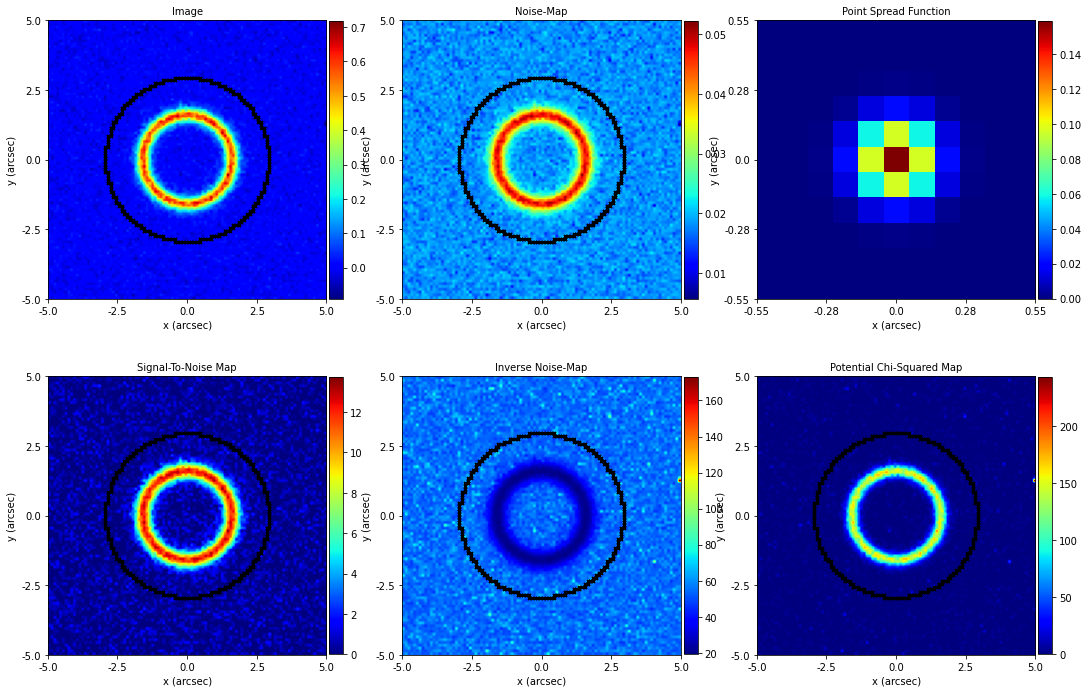

In [3]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

To change the priors on specific parameters, we create our galaxy models and then, simply, customize their priors.

In [4]:
lens = af.Model(al.Galaxy, redshift=0.5, mass=al.mp.SphericalIsothermal)
source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.SphericalExponential)

To change priors, we use the `prior` module of PyAutoFit (imported as af). These priors chain our `GalaxyModel` to the 
non-linear search. Thus, it tells **PyAutoLens** where to search non-linear parameter space.

These two lines change the centre of the lens galaxy's total mass distribution to UniformPriors around the coordinates 
(-0.1", 0.1"). For real lens modeling, this might be done by visually inspecting the centre of emission of the lens 
_Galaxy_`s light.

The word `mass` corresponds to the word we used when setting up the `GalaxyModel` above.

In [5]:
lens.mass.centre_0 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.1)
lens.mass.centre_1 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.1)

Lets also change the prior on the lens galaxy's einstein radius to a GaussianPrior centred on 1.4". For real lens 
modeling, this might be done by visually estimating the radius the lens's arcs / ring appear.

In [6]:
lens.mass.einstein_radius = af.GaussianPrior(mean=1.4, sigma=0.2)

We can also customize the source galaxy, lets say we believe it is compact and limit its effective radius.

In [7]:
source.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=2.0)

Like in the previous tutorial, we use a `SettingsPhaseImaging` object to specify our model-fitting procedure uses a 
regular `Grid2D`.

In [8]:
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D, sub_size=2)

settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

We can now create this custom phase like we did a hyper phase before. If you look at the `model.info` file in the 
output of the non-linear search, you'll see that the priors have indeed been changed.

Dynesty has begun running - checkout the autolens_workspace/output/2_custom_priors folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!


INFO:root:phase_t2_custom_priors already completed, skipping non-linear search.


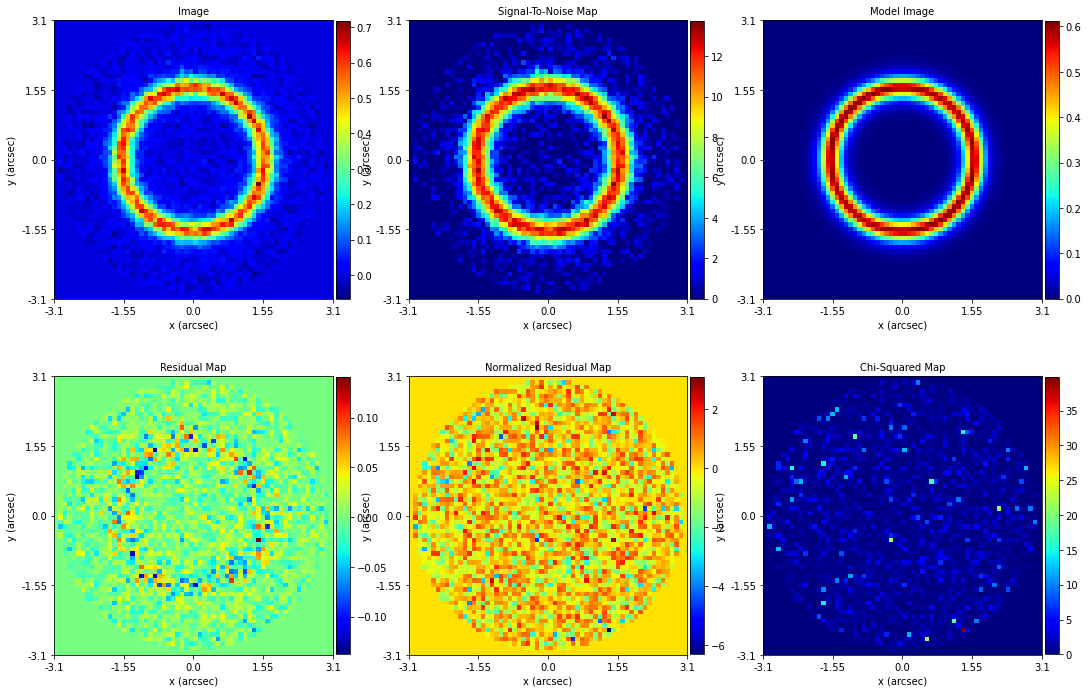

Dynesty has finished run - you may now continue the notebook.


In [9]:
phase = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="howtolens", name="phase_t2_custom_priors", n_live_points=40
    ),
    settings=settings,
    galaxies=af.Collection(lens=lens, source=source),
)

print(
    "Dynesty has begun running - checkout the autolens_workspace/output/2_custom_priors"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

result = phase.run(dataset=imaging, mask=mask)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

print("Dynesty has finished run - you may now continue the notebook.")

And, we're done. This tutorial had some pretty difficult concepts to wrap your head around. However, I can`t emphasize 
enough how important it is that you develop an intuition for non-linear searches and the notion of a non-linear 
parameter space. Becoming good at lens modeling is all being able to navigate a complex, degenerate and highly 
non-linear parameter space! Luckily, we're going to keep thinking about this in the next set of tutorials, so if 
you're not feeling too confident yet, you will be soon!

Before continuing to the next tutorial, I want you think about whether anything could go wrong when we search a 
non-linear parameter space. Is it possible that we won't find the highest log likelihood lens model? Why might this be?

Try and list 3 reasons why this might happen. In the next tutorial, we'll learn about just that - failure!